In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

dataset = pd.read_csv("../data/cleanData.csv")

In [15]:
dataset.head(2)

,Unnamed: 0,accession_number,artist,title,date,decade,country,collection,sight,length,...,abrasions_frame,flaking_frame,losses_frame,dented_frame,chipped_frame,cracking_frame,corner_damage_frame,mitres_separating_frame,work_loose_frame,surface_dirt_along_top_edge_frame
0,0,Upvma-Iii.00240,"Gallardo, Alladin",Ifugao Warrior,1947,1940,Philippines,Vargas Museum (Philippines),635X 480,635.00,...,1,0,1,1,1,0,1,0,0,0
1,1,Upvma-Iii.00085,"Ancheta, Isidro",Guadalupe Ruins,1939,1930,Philippines,Vargas Museum (Philippines),670 X 405,670.00,...,1,0,0,1,0,0,1,0,0,0


Predicting `ground_layer_application`

In [4]:
dataset['ground_condition'] = dataset['ground_condition'].fillna('Condition Unspecified')
colnames = ['ground_layer_application', 'ground_layer_limit', 'ground_layer_thickness', 'size_layer_visible', 'ground_condition',
            'coloured_ground', 'id_sulphate', 'id_carbonate', 'uniform_application', 'ground_proprietary_paint', 'collection']

One hot encode categorical data with more than two values

In [5]:
prediction_set = dataset[colnames]
one_hot = pd.get_dummies(prediction_set['ground_layer_limit'])
prediction_set = prediction_set.drop('ground_layer_limit', axis=1)
prediction_set = prediction_set.join(one_hot)

one_hot = pd.get_dummies(prediction_set['ground_layer_thickness'])
prediction_set = prediction_set.drop('ground_layer_thickness', axis=1)
prediction_set = prediction_set.join(one_hot, lsuffix="limit", rsuffix="thickness")

one_hot = pd.get_dummies(prediction_set['collection'])
prediction_set = prediction_set.drop('collection', axis=1)
prediction_set = prediction_set.join(one_hot)

one_hot = pd.get_dummies(prediction_set['ground_condition'])
prediction_set = prediction_set.drop('ground_condition', axis=1)
prediction_set = prediction_set.join(one_hot)
prediction_set.columns = prediction_set.columns.astype(str)

Split data into training, validation and testing set

In [6]:
temp = prediction_set[(prediction_set['ground_layer_application'] != 'Unspecified') & (prediction_set['ground_layer_application'] != 'Unsure')]
train = temp.sample(frac = 0.8, random_state=25)
valid = temp.drop(train.index)
test = prediction_set[(prediction_set['ground_layer_application'] == 'Unspecified') | (prediction_set['ground_layer_application'] == 'Unsure')]

In [7]:
X_train = train.drop('ground_layer_application', axis=1)
y_train = train['ground_layer_application']

X_valid = valid.drop('ground_layer_application', axis=1)
y_valid = valid['ground_layer_application']

X_test = test.drop('ground_layer_application', axis=1)

In [8]:
X_train.shape, X_valid.shape

((147, 23), (37, 23))

In [9]:
X_test.shape

(24, 23)

### Train baseline model: Bernoulli Naive Bayes

In [10]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [19]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
valid_prediction = bnb.predict(X_valid)
test_prediction = bnb.predict(X_test)
print("Training Accuracy:", bnb.score(X_train, y_train))
print("Holdout Accuracy:", bnb.score(X_valid, y_valid))

Training Accuracy: 0.7891156462585034
Holdout Accuracy: 0.8108108108108109


In [12]:
print("Training data class distribution: ", Counter(y_train))
print("Validation data class distribution: ", Counter(y_valid))
print("Validation prediction distribution: ", Counter(valid_prediction))

Training data class distribution:  Counter({'Artist Applied Ground': 77, 'Commercial Ground': 70})
Validation data class distribution:  Counter({'Commercial Ground': 24, 'Artist Applied Ground': 13})
Validation prediction distribution:  Counter({'Commercial Ground': 23, 'Artist Applied Ground': 14})


Evaluate using confusion matrix

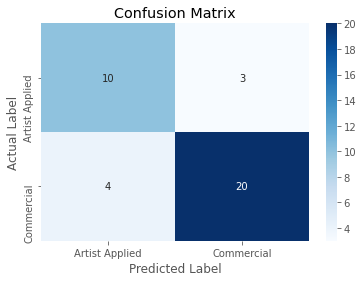

In [18]:
cm = confusion_matrix(y_valid, valid_prediction)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
            xticklabels = ['Artist Applied', 'Commercial'],
            yticklabels = ['Artist Applied', 'Commercial'])
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix')
plt.show()

Print predictions

In [20]:
test_prediction

array(['Commercial Ground', 'Commercial Ground', 'Commercial Ground',
       'Commercial Ground', 'Commercial Ground', 'Commercial Ground',
       'Artist Applied Ground', 'Commercial Ground',
       'Artist Applied Ground', 'Commercial Ground', 'Commercial Ground',
       'Commercial Ground', 'Commercial Ground', 'Artist Applied Ground',
       'Commercial Ground', 'Artist Applied Ground',
       'Artist Applied Ground', 'Commercial Ground', 'Commercial Ground',
       'Commercial Ground', 'Commercial Ground', 'Artist Applied Ground',
       'Artist Applied Ground', 'Artist Applied Ground'], dtype='<U21')